In [1]:
import random, math, PIL, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Dropout, ZeroPadding2D, Flatten, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam, Adamax

warnings.filterwarnings('ignore')

sns.set(rc = {"axes.facecolor" : "#EDE9DE",
              "figure.facecolor": "#D8CA7E"})

In [2]:
# 데이터 불러오기

data_dir = './Portraits/' # 파일 경로
batchs = 64

# 이미지 파일을 image_size 크기대로 `tf.data.Dataset` 형태로 변환
data = image_dataset_from_directory(data_dir, label_mode=None, image_size=(64, 64), batch_size=batchs)
data

Found 4117 files belonging to 1 classes.


<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [3]:
# 데이터 정규화
norm_data = data.map(lambda x: (x / 255.0))

In [4]:
# Generator Part (생성자)

latent_dim = 100   # 잠재 공간 (Latent Space / Latent Dimention)
g_resolution=2     # 해상도

generator = Sequential()

# First Block
generator.add(Dense(4*4*256, activation='relu', input_dim = latent_dim))
generator.add(Reshape((4, 4, 256))) 
generator.add(UpSampling2D()) # 8 * 8 * 256
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))


generator.add(Activation('relu'))
generator.add(UpSampling2D()) # 16 * 16 * 256
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))


generator.add(Activation('relu'))
generator.add(UpSampling2D()) # 32 * 32 * 256
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))


generator.add(Activation('relu'))
generator.add(UpSampling2D()) # 64 * 64 * 256
generator.add(Conv2D(128, kernel_size=3, padding='same')) # 64 * 64 * 128
generator.add(BatchNormalization(momentum=0.8))


# Last Block
generator.add(Activation('relu'))
generator.add(Conv2D(3, kernel_size=3, padding='same')) # 64 * 64 * 3

# Last Activation
generator.add(Activation('tanh'))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

In [5]:
# 생성 예제
seed = tf.random.normal([1, latent_dim])
print(seed)

Gen_por = generator(seed)

# plt.axis('off')
# plt.imshow(Gen_por[0,:,:,0]);

tf.Tensor(
[[-0.40198702 -0.43197885 -1.6890296  -0.26817992 -0.8878905  -0.14026268
  -1.0408379  -0.35697645 -0.30011463 -0.31413952  2.0702665  -0.11496434
  -1.2294735  -1.5444796  -0.32235     0.09433633  0.4965181  -1.0970576
  -0.26542962 -0.2140924   0.22420685 -1.15318    -1.0442917   1.5288051
   1.2761214   0.688363   -0.04671202  0.11660041  0.45464048  2.7589796
   0.9101327  -0.3430367  -0.071275    0.21822762  0.6489019   0.9186619
   0.21725367  1.5827035  -2.0870864  -1.8825048  -0.02477076 -0.7719764
  -0.1691485   0.0595735   0.11027303  0.57036036  0.5251373  -0.19395763
   0.68797004 -0.65115196  1.0983944  -2.0788083  -1.3641062   0.03746206
  -0.7860627   0.28964272 -0.16553201 -1.6622937   0.3423317   0.3449649
   0.38250205 -0.656167    0.50470424  1.1730162  -0.2222578  -0.6267161
   0.38396773 -1.1234404   0.6153011   1.0644042   1.4381751   0.96077406
  -0.15370056  0.07693179 -0.11273183  1.8919286  -0.9713187  -0.6746117
   0.46815217 -1.158825   -0.505205

In [6]:
# Discriminator Part (판별자)

discriminator = Sequential()

# First Block
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64, 64, 3), padding='same')) # 32 * 32 * 32
discriminator.add(LeakyReLU(alpha=0.2))  # 소량의 음의 기울기도 다음 Layer로 전달
discriminator.add(Dropout(0.25))


discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same')) # 16 * 16 * 64
discriminator.add(ZeroPadding2D(padding= ((0,1), (0,1)))) # 우측과 하단쪽 두 곳에 0 패딩 추가 # 17 * 17 * 64
discriminator.add(BatchNormalization(momentum=0.8))


discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))  # (Input - Kernel_Size + 2 * Padding) / Strides
                                                                           # Applied same padding input = Input + 2 * Padding
                                                                           # Same padding = (Kernel_size - 1) / 2
                                                                           # (17 + 2) - 3 + 2 * 1 / 2 = 9  : 9 * 9 * 128
discriminator.add(BatchNormalization(momentum=0.8))


discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same')) # 5 * 5 * 256
discriminator.add(BatchNormalization(momentum=0.8))


discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=2, padding='same')) # 3 * 3 * 512
discriminator.add(BatchNormalization(momentum=0.8))


# Last Block
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten()) # 3 * 3 * 512 = 4608
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [7]:
# 판별 예제
Discriminator_Verdict = discriminator(Gen_por)
print (Discriminator_Verdict)

tf.Tensor([[0.50181013]], shape=(1, 1), dtype=float32)


In [8]:
# GAN 

class GAN(tf.keras.Model):
    # 초기화
    def __init__(self, discriminator, generator, latent_dim): 
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        # 잠재 공간 내 임의의 점 추출
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # 생성된 가짜 이미지 디코딩
        generated_images = self.generator(seed)
        
        # 실제 이미지와 결합
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # 판별자 (진짜 / 가짜 구분) 라벨 생성
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        
        ### 레이블에 랜덤 노이즈 추가 - 중요 과정
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # ========== 판별자 (Discriminator) 학습 부분 ==========
        
        # GradientTape() : 컨텍스트(Context) 내 실행된 모든 연산을 테이프(Tape)에 기록
        with tf.GradientTape() as tape:
            # 예측
            predictions = self.discriminator(combined_images)
            # Loss 계산
            d_loss = self.loss_fn(labels, predictions)
        
        # Gradients 계산 과정
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)    
        # Backpropagation (오차역전파) - 가중치 업데이트
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        # 잠재 공간 내 임의의 점 추출
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # 실제 이미지 추출 (라벨 1)
        misleading_labels = tf.zeros((batch_size, 1))
        
        # ========== 생성자 (Generator) 학습 / 판별자 가중치 업데이트 금지 ==========
        with tf.GradientTape() as tape:
            # 예측 - 생성자로 생선된 이미지를 판별자로 예측
            predictions = self.discriminator(self.generator(seed))
            # Loss 계산
            g_loss = self.loss_fn(misleading_labels, predictions)
        
        # Gradients 계산 과정
        grads = tape.gradient(g_loss, self.generator.trainable_weights)    
        # Backpropagation (오차역전파) - 가중치 업데이트 ***** 생성자에 대한 가중치만 업데이트 *****
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        # 평가지표 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [9]:
# 모델 학습 정의

# 에포크 수 정의
epochs = 20

# 옵티마이저 정의
discriminator_opt = Adamax(0.5e-5, 0.5)
generator_opt = Adamax(1e-4, 0.5)

# 손실함수 정의
loss_fn = tf.keras.losses.BinaryCrossentropy()


# 모델 정의
gan_model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# 모델 컴파일
gan_model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

# 모델 학습
history = gan_model.fit(data, epochs=epochs)

Epoch 1/20
65/65 [==============================] - 60s 772ms/step - d_loss: 0.4604 - g_loss: 0.6705
Epoch 2/20
65/65 [==============================] - 49s 725ms/step - d_loss: 0.4373 - g_loss: 0.6608
Epoch 3/20
65/65 [==============================] - 49s 727ms/step - d_loss: 0.4329 - g_loss: 0.6658
Epoch 4/20
65/65 [==============================] - 50s 727ms/step - d_loss: 0.4281 - g_loss: 0.6733
Epoch 5/20
65/65 [==============================] - 49s 726ms/step - d_loss: 0.4241 - g_loss: 0.6802
Epoch 6/20
65/65 [==============================] - 49s 726ms/step - d_loss: 0.4182 - g_loss: 0.6910
Epoch 7/20
65/65 [==============================] - 50s 729ms/step - d_loss: 0.4122 - g_loss: 0.7030
Epoch 8/20
65/65 [==============================] - 49s 726ms/step - d_loss: 0.4048 - g_loss: 0.7160
Epoch 9/20
65/65 [==============================] - 49s 727ms/step - d_loss: 0.3965 - g_loss: 0.7343
Epoch 10/20
65/65 [==============================] - 49s 727ms/step - d_loss: 0.3861 - g_lo

In [10]:
# 생성할 이미지 수
num_img=16

# 생성 및 이미지 저장 함수 선언
def Potrait_Generator():
    Generated_Paintings = [] # 생성 이미지 컨테이너
    seed = tf.random.normal([num_img, latent_dim]) # (생성 이미지 수, 잠재 공간 크기)
    generated_image = generator(seed) # 생성자로 생성
#     generated_image *= 255 # 스케일 복원
    generated_image = generated_image.numpy()
    
    # 생성된 이미지 별로 저장
    for i in range(num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
        Generated_Paintings.append(img)
        img.save("./Gen/Potraits{:02d}.png".format(i)) 
    return 

# 실행
Images = Potrait_Generator()

In [22]:
# 생성 데이터 불러오기

data_dir_gen = './Gen/' # File Directory
batchs = 64
data_gen = image_dataset_from_directory(data_dir_gen, label_mode=None, image_size=(64, 64))

Found 16 files belonging to 1 classes.


In [35]:
# 잠재 공간에 Seed 생성
seed = tf.random.normal([16, latent_dim])

# 이미지 생성
fake = generator.predict(seed)

# 생성된 이미지의 실제 여부 판단
result = discriminator.predict(fake)

1/1 [==============================] - 0s 247ms/step


In [42]:
gan_model.train_step(fake)

{'d_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.38030335>,
 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.78005624>}

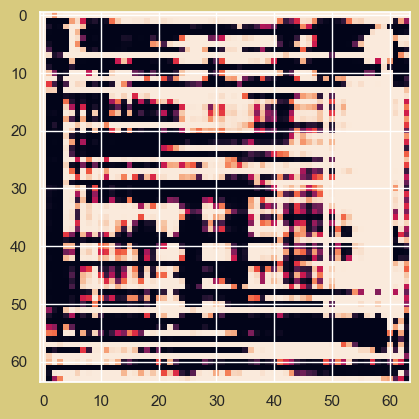

In [39]:
plt.imshow(fake[0,:,:,0]);

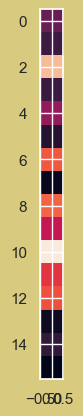

In [40]:
plt.imshow(result);